In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Outline 

1. DQN network which is part of the table and strategy used by the agent

2. Epsilong greedy strategy also used by the agent. 

I changed so that the q network actually recognizes there is no reward for being done, optimizing the performance. 

Basically previous I arbitrarily said R at last i was a very negative value. While that's fine, it's important that the max q prediction is also 0. Now I do masking to do this!


In [2]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 1e-3
target_update = 10
memory_size = 10000
lr = 0.001
num_episodes = 1000

In [3]:
env = gym.make("CartPole-v0")

In [4]:
class DQN(nn.Module):
    
    """
    Input the shape of observations, which is 4 for cartpole.
    """
    def __init__(self, obs_shape):
        super().__init__()
            
        self.fc1 = nn.Linear(in_features=obs_shape, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.fc3 = nn.Linear(in_features=32,out_features=24)
        self.out = nn.Linear(in_features=24, out_features=2)
    
    def forward(self, t):
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = F.relu(self.fc3(t))

        t = self.out(t)
        return t
    
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)
    
    
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                # convert current state to a tensor
                state = torch.tensor(state).reshape(-1,4).float()
                return policy_net(state).argmax().to(self.device) # exploit

In [5]:
policy_net = DQN(obs_shape=4).to(device)
target_net = DQN(obs_shape=4).to(device) #this one just gets updated occasionally

In [6]:
#policy_net(torch.randn(2,4)) #confirm this works, output is 2 actions of 2 random obs. 

Now replay memory. 

In [7]:
# utility functions

def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.tensor(batch.state)
    t2 = torch.tensor(batch.action)
    t3 = torch.tensor(batch.reward)
    t4 = torch.tensor(batch.next_state)
    t5 = torch.tensor(batch.done)
#should I include a done bool?
    return (t1.float(),t2.float(),t3.float(),t4.float(),t5.float())


Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward','done')
)

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [8]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1).long())
    
    @staticmethod        
    def get_next(target_net, next_states,dones):  #if done, need to include to set as 0   
        done_mask = dones == 1 # if true, set to 0
        values = target_net(next_states).max(dim=1)[0].detach()
        values[done_mask] = 0.
        return values


In [9]:
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, env.action_space.n, device)
memory = ReplayMemory(memory_size)
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
RENDER_TIME = 5

In [10]:
episode_durations = []
RENDER = True
for episode in range(num_episodes):
    state = env.reset() #initial state
    done = False
    timestep = 0
    while not done:
        if RENDER:
            env.render()
        timestep += 1
        action = agent.select_action(state, policy_net).item()
        next_state, reward, done, info = env.step(action)
        
        memory.push(Experience(state, action, next_state, reward,done))
        
        state = next_state

        #once enough replays are collected so it is possible to learn. 
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states, dones = extract_tensors(experiences)
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states,dones)
            target_q_values = (next_q_values * gamma) + rewards
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    episode_durations.append(timestep)
    if episode % RENDER_TIME == 0:
        RENDER = True
    else: RENDER = False
    
env.close()


KeyboardInterrupt: 

I owe the utmost gratitude to deeplizard, Sentdex, and tds for getting me started on this, but here is how you create a pytorch dqn using the default observation values !

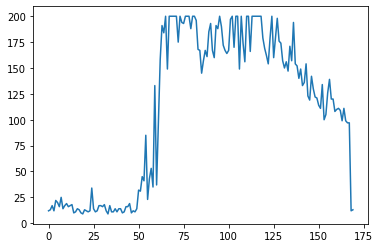

In [12]:
plt.plot(episode_durations)